<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/Lab2_DL_part2_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from time import time
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import itertools
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train = True, 
                                                        transform = train_transform,
                                                        target_transform = None,
                                                        download = download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train = False, 
                                                       transform = test_transform,
                                                       target_transform = None,
                                                       download = download)
def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset




Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_set, _ = test_train_split(fmnist_dataset_train)
train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)


In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, num_classes))
        
    def forward(self, x):       
        return self.model(x)
    

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 256]         200,960
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
              ReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 205,610
Trainable params: 205,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.78
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

def train_model(model, train_set, valid_set, 
                loss_fn, opt, 
                n_epochs: int, 
                device = device,
                return_train_metrics = False):
    
    train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)
    valid_loader = DataLoader(valid_set, batch_size = 128,
                                           shuffle = False,
                                           num_workers = 2)
    
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []
        
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            with torch.no_grad():
                _ = model.eval()
                y_pred = predictions.max(1)[1] 
                ep_train_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float)) / len(y_batch.cpu()))
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1] 
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    return train_loss, train_accuracy, val_loss, val_accuracy 

def evaluate_model(model, test_set, loss_fn, opt):
    test_loader = DataLoader(test_set, batch_size = 128,
                                          shuffle = False,
                                          num_workers = 2)
    _ = model.eval()
    print("\n\n TESTING MODEL...")
    losses = []
    metrics = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            y_pred = predictions.max(1)[1]
            losses.append(loss.item())
            metrics.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))
            
    print(f"\t test loss: {np.mean(losses):.6f}")
    print(f"\t test accuracy: {np.mean(metrics):.3f}")

    return np.mean(losses), np.mean(metrics)

Epoch 1 of 15 took 6.018s
	  training loss: 0.573729
	validation loss: 0.442608
	validation accuracy: 0.842
Epoch 2 of 15 took 5.971s
	  training loss: 0.412682
	validation loss: 0.383179
	validation accuracy: 0.862
Epoch 3 of 15 took 5.964s
	  training loss: 0.366869
	validation loss: 0.369850
	validation accuracy: 0.864
Epoch 4 of 15 took 5.968s
	  training loss: 0.337731
	validation loss: 0.351267
	validation accuracy: 0.871
Epoch 5 of 15 took 5.939s
	  training loss: 0.319699
	validation loss: 0.336608
	validation accuracy: 0.877
Epoch 6 of 15 took 5.956s
	  training loss: 0.299800
	validation loss: 0.322285
	validation accuracy: 0.883
Epoch 7 of 15 took 5.934s
	  training loss: 0.283910
	validation loss: 0.312816
	validation accuracy: 0.886
Epoch 8 of 15 took 5.927s
	  training loss: 0.270799
	validation loss: 0.305896
	validation accuracy: 0.888
Epoch 9 of 15 took 5.921s
	  training loss: 0.260227
	validation loss: 0.310427
	validation accuracy: 0.885
Epoch 10 of 15 took 5.950s
	

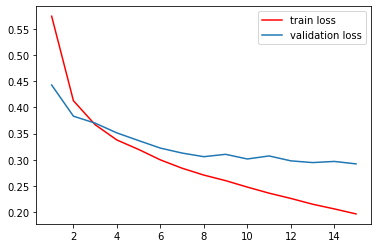

In [ ]:
# Your experiments, training and validation loops here
#unlucky number :)
n_epochs = 15
train_set, valid_set = test_train_split(fmnist_dataset_train)
train_loss, _, val_loss, val_accuracy = train_model(model, train_set, valid_set,
                                                loss_func, opt, n_epochs)
_ = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
plt.plot(np.arange(1, n_epochs + 1, 1), train_loss, color = 'r', label = 'train loss')
plt.plot(np.arange(1, n_epochs + 1, 1), val_loss, label = 'validation loss')
plt.legend(loc = 'best')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1,
                 input_shape = 28 * 28, num_classes = 10, input_channels = 1, hidden_dim = 16):
        super(self.__class__, self).__init__()
        hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            prev_layer_input_dim = hidden_dim
            
        self.model.add_module('classifier', 
                               torch.nn.Linear(prev_layer_input_dim, num_classes)) 
        
    def forward(self, x):       
        return self.model(x)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 126]          98,910
            Linear-3                   [-1, 10]           1,270
Total params: 100,180
Trainable params: 100,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
train_set, _ = test_train_split(fmnist_dataset_train, .66)
loss_func = nn.CrossEntropyLoss()
factor_range = 7

def get_overfitting(factor_range):  
    test = {"loss": [], "error": []}
    train = {"loss": [], "error": []}
    hidden_dim = 8
    for _ in range(factor_range):
        print("hidden_dim = ", hidden_dim)
        model = OverfittingNeuralNetwork(n_layers = 3, hidden_dim = hidden_dim).to(device)
        opt = torch.optim.Adam(model.parameters())
        train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                    valid_set,
                                                    loss_func, opt, 10)

        test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
        train['error'].append(1. - np.mean(val_accuracy))
        test['error'].append(1. - test_accuracy)
        hidden_dim *= 2
    return train, test
train_data, test_data = get_overfitting(factor_range = factor_range)
# Your experiments, come here

hidden_dim =  8
Epoch 1 of 10 took 5.057s
	  training loss: 1.059207
	validation loss: 0.643598
	validation accuracy: 0.770
Epoch 2 of 10 took 4.786s
	  training loss: 0.585268
	validation loss: 0.546242
	validation accuracy: 0.811
Epoch 3 of 10 took 4.797s
	  training loss: 0.528634
	validation loss: 0.507925
	validation accuracy: 0.822
Epoch 4 of 10 took 4.794s
	  training loss: 0.501249
	validation loss: 0.491199
	validation accuracy: 0.829
Epoch 5 of 10 took 4.741s
	  training loss: 0.483432
	validation loss: 0.487356
	validation accuracy: 0.827
Epoch 6 of 10 took 4.699s
	  training loss: 0.469026
	validation loss: 0.464820
	validation accuracy: 0.839
Epoch 7 of 10 took 4.774s
	  training loss: 0.459037
	validation loss: 0.456865
	validation accuracy: 0.838
Epoch 8 of 10 took 4.730s
	  training loss: 0.452295
	validation loss: 0.465164
	validation accuracy: 0.837
Epoch 9 of 10 took 4.895s
	  training loss: 0.444612
	validation loss: 0.450813
	validation accuracy: 0.844
Epoch 10 of 

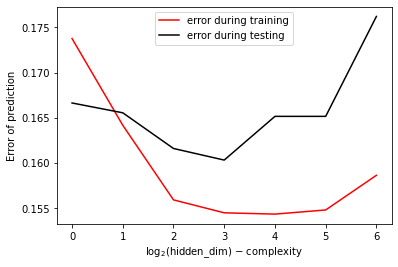

In [ ]:
plt.ylabel("Error of prediction")
plt.plot(np.arange(0, factor_range),        
         train_data['error'], color = 'r', label = "error during training")
plt.plot(np.arange(0, factor_range), 
         test_data['error'], color = 'k', label = "error during testing")
plt.xlabel("$\log_2$(hidden_dim) $-$ complexity"); plt.legend(loc = "best")


Here we can see sign of overfitting. Error is growing pretty fast.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1, input_shape = 28 * 28, num_classes = 10, 
                 input_channels = 1, hidden_dim = 16):
        super(self.__class__, self).__init__()
        hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            self.model.add_module("BatchNorm {}".format(layer + 1), 
                                  torch.nn.BatchNorm1d(hidden_dim))
            self.model.add_module("Dropout {}".format(layer + 1), nn.Dropout(.5))
            
            prev_layer_input_dim = hidden_dim
            
        self.model.add_module('classifier', nn.Linear(prev_layer_input_dim, num_classes))
                       
        
    def forward(self, x):       
        out = self.model(x)
        return out
                            

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 16]          12,560
       BatchNorm1d-3                   [-1, 16]              32
           Dropout-4                   [-1, 16]               0
            Linear-5                   [-1, 10]             170
Total params: 12,762
Trainable params: 12,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [ ]:
train_set, _ = test_train_split(fmnist_dataset_train, .66)
loss_func = nn.CrossEntropyLoss()
factor_range = 7

test_data = {"loss": [], "error": []}
train_data = {"loss": [], "error": []}
hidden_dim = 8
for _ in range(factor_range):
    print("hidden_dim = ", hidden_dim)
    model = FixedNeuralNetwork(n_layers = 3, hidden_dim = hidden_dim).to(device)
    opt = torch.optim.Adam(model.parameters())
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                valid_set,
                                                loss_func, opt, 10)

    test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
    train_data['error'].append(1. - np.mean(val_accuracy))
    test_data['error'].append(1. - test_accuracy)
    hidden_dim *= 2

# Your experiments, come here

hidden_dim =  8
Epoch 1 of 10 took 4.990s
	  training loss: 1.144632
	validation loss: 0.700981
	validation accuracy: 0.750
Epoch 2 of 10 took 4.987s
	  training loss: 0.635301
	validation loss: 0.562588
	validation accuracy: 0.797
Epoch 3 of 10 took 4.942s
	  training loss: 0.560287
	validation loss: 0.519770
	validation accuracy: 0.813
Epoch 4 of 10 took 5.065s
	  training loss: 0.532378
	validation loss: 0.502101
	validation accuracy: 0.822
Epoch 5 of 10 took 5.009s
	  training loss: 0.514776
	validation loss: 0.494916
	validation accuracy: 0.824
Epoch 6 of 10 took 4.954s
	  training loss: 0.505388
	validation loss: 0.487063
	validation accuracy: 0.828
Epoch 7 of 10 took 4.901s
	  training loss: 0.499227
	validation loss: 0.477926
	validation accuracy: 0.831
Epoch 8 of 10 took 4.950s
	  training loss: 0.491427
	validation loss: 0.475569
	validation accuracy: 0.833
Epoch 9 of 10 took 4.935s
	  training loss: 0.488847
	validation loss: 0.469008
	validation accuracy: 0.835
Epoch 10 of 

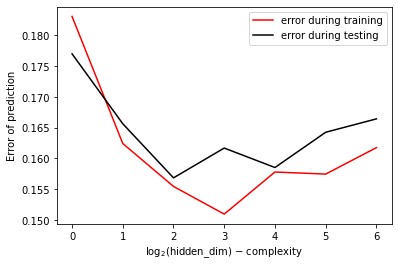

In [ ]:
plt.ylabel("Error of prediction")
plt.plot(np.arange(0, factor_range),        
         train_data['error'], color = 'r', label = "error during training")
plt.plot(np.arange(0, factor_range), 
         test_data['error'], color = 'k', label = "error during testing")
plt.xlabel("$\log_2$(hidden_dim) $-$ complexity"); plt.legend(loc = "best")


### Conclusions:
_Write down small report with your conclusions and your ideas._

_One of the most explicit signs of overfitting_ is that behaviour of a model's loss during training and validation is different: e.g. while loss on train in decreasing, loss on val is rising. That means that the model "knows" training set too well, however, its generalizing ability not too high for val set.

To avoid this we apply _regularization technics_ such as `dropout` and `batch_normaliztion` to the model. We could use weight decay that works like `l2-reg` but this is related to optimizer not to our model.

I tried to plot error of prediction (1. - accuracy_score) w.r.t. complexity of the model. I found 2 ways to vary complexity: vary #layers of hidden layer dimension. I found the second way more natural.

So, this method can help us avoid oferfitting for a long time $-$ `dropout` and `batch_normaliztion` do not allow the model to memorize train set too fast and increase its ability to generalize given test set.

To sum up, i think it is really useful to use `dropout` (selecting the rate is mnemonic rule that depends what rate of reg u want to have) and `batch_normaliztion` because scaling features sometimes decreases internal covariance shift and makes the loss smoother.